In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
binance_df = pd.read_csv('../data/csv/Binance.csv')
bybit_df = pd.read_csv('../data/csv/bybit.csv')
kucoin_df = pd.read_csv('../data/csv/kuCoin.csv')
okx_df = pd.read_csv('../data/csv/okx.csv')

# 2. Data cleaning

In [21]:
#replace string time by datetime
binance_df['time'] = pd.to_datetime(binance_df['time'])
bybit_df['time'] = pd.to_datetime(bybit_df['time'])
kucoin_df['time'] = pd.to_datetime(kucoin_df['time'])
okx_df['time'] = pd.to_datetime(okx_df['time'])

In [ ]:
#check wether values for quantity and price are numeric
print(binance_df.dtypes)
print(bybit_df.dtypes)
print(kucoin_df.dtypes)
print(okx_df.dtypes)

In [ ]:
#check for missing values
print(binance_df.isnull().sum())
print(bybit_df.isnull().sum())
print(kucoin_df.isnull().sum())
print(okx_df.isnull().sum())

In [ ]:
#Plot the price of the 4 exchanges on different subplots
fig, axs = plt.subplots(4, 1, figsize=(15, 15) , sharey=True , sharex=True)
axs[0].plot(binance_df['time'], binance_df['price'])
axs[0].set_title('Binance')
axs[1].plot(bybit_df['time'], bybit_df['price'])
axs[1].set_title('Bybit')
axs[2].plot(kucoin_df['time'], kucoin_df['price'])
axs[2].set_title('Kucoin')
axs[3].plot(okx_df['time'], okx_df['price'])
axs[3].set_title('Okx')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


In [ ]:
#Remove trades with very low price (outliers) in okx
okx_df['price'].describe()

In [ ]:
okx_df[okx_df.price < 5]['price'].describe()

Weird prices for Okx : filter out these trades as they will bias our statistical analysis.

In [3]:
okx_df  = okx_df[okx_df.price > 5]

In [ ]:
#Save the cleaned dataframes
binance_df.to_csv('../../data/csv/Binance.csv')
bybit_df.to_csv('../../data/csv/bybit.csv')
kucoin_df.to_csv('../../data/csv/kuCoin.csv')
okx_df.to_csv('../../data/csv/okx.csv')

# 3. Data Exploration

In [11]:
#Set the index to time
binance_df.set_index('time', inplace=True)
bybit_df.set_index('time', inplace=True)
kucoin_df.set_index('time', inplace=True)
okx_df.set_index('time', inplace=True)

In [18]:
#drop Unnamed: 0 column
binance_df.drop(columns=['Unnamed: 0'], inplace=True)
bybit_df.drop(columns=['Unnamed: 0'], inplace=True)
kucoin_df.drop(columns=['Unnamed: 0'], inplace=True)
okx_df.drop(columns=['Unnamed: 0'], inplace=True)

#### Trading volume stats

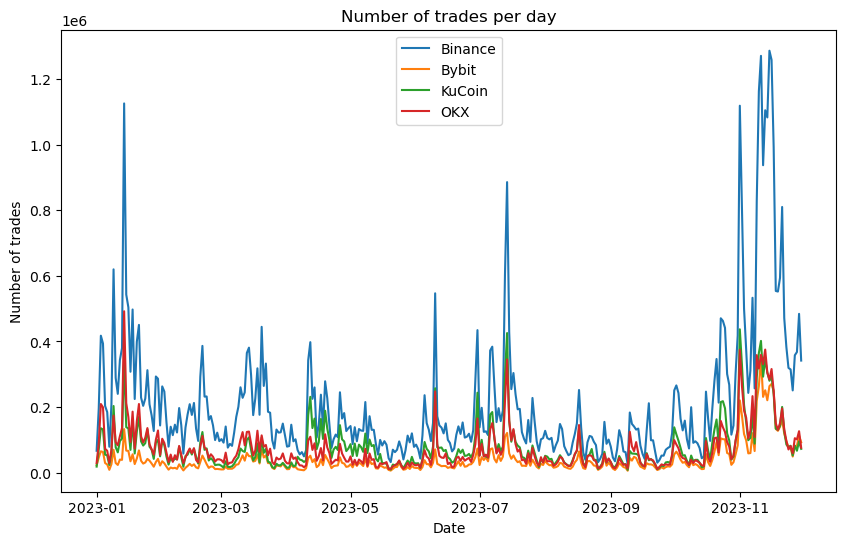

In [22]:
import matplotlib.pyplot as plt

# Resample the dataframes to get the number of trades per day
binance_daily = binance_df.resample('D', on='time').size()
bybit_daily = bybit_df.resample('D', on='time').size()
kucoin_daily = kucoin_df.resample('D', on='time').size()
okx_daily = okx_df.resample('D', on='time').size()

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(binance_daily.index, binance_daily.values, label='Binance')
plt.plot(bybit_daily.index, bybit_daily.values, label='Bybit')
plt.plot(kucoin_daily.index, kucoin_daily.values, label='KuCoin')
plt.plot(okx_daily.index, okx_daily.values, label='OKX')

plt.title('Number of trades per day')
plt.xlabel('Date')
plt.ylabel('Number of trades')
plt.legend()

plt.show()

#### Price stats

In [23]:
# Define a function to calculate the statistics for a dataframe
def calculate_statistics(df, name):
    # Convert the 'time' column to datetime and set it as the index
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    
    # Calculate the volume of each trade
    df['volume'] = df['price'] * df['qty']
    
    # Calculate the daily statistics
    daily = df.resample('D')
    avg_daily_volume = daily['volume'].sum().mean() / 1_000_000  # in millions
    avg_daily_trades = daily.size().mean() / 1_000  # per thousands
    avg_trade_size = df['qty'].mean()
    avg_daily_volatility = daily['price'].std().mean()
    
    # Return the statistics as a series
    return pd.Series({
        'Average daily volume (millions $)': avg_daily_volume,
        'Average daily number of trades (thousands)': avg_daily_trades,
        'Average trade size': avg_trade_size,
        'Average daily volatility': avg_daily_volatility,
    }, name=name)

# Calculate the statistics for each dataset
binance_stats = binance_df.copy()
binance_stats = calculate_statistics(binance_stats, 'Binance')
bybit_stats = bybit_df.copy()
bybit_stats = calculate_statistics(bybit_stats, 'Bybit')
kucoin_stats = kucoin_df.copy()
kucoin_stats = calculate_statistics(kucoin_stats, 'KuCoin')
okx_stats = okx_df.copy()
okx_stats = calculate_statistics(okx_stats, 'OKX')

# Combine the statistics into a dataframe
stats_df = pd.concat([binance_stats, bybit_stats, kucoin_stats, okx_stats], axis=1)

# Print the statistics
print(stats_df)

                                               Binance      Bybit     KuCoin  \
Average daily volume (millions $)           134.578215  18.227298  14.967981   
Average daily number of trades (thousands)  214.445407  40.990737  77.671889   
Average trade size                           23.465971  15.228716   7.657933   
Average daily volatility                      0.442452   0.442755   0.448905   

                                                  OKX  
Average daily volume (millions $)           24.433596  
Average daily number of trades (thousands)  73.477602  
Average trade size                          12.427097  
Average daily volatility                     0.446851  


#### Return stats

In [24]:
def calculate_returns(data, period):
    resampled_data = data['price'].resample(period).last()  # Resample and take the last price of each period
    returns = resampled_data.pct_change()  # Calculate percentage change
    return returns.dropna() 

In [25]:
def compute_price_dynamics_stats(df, name) :

    #compute 5-min returns
    five_min_returns = calculate_returns(df, '5T')

    #compute 1-hour returns
    one_hour_returns = calculate_returns(df, '1H')
    
    #compute daily returns
    daily_returns = calculate_returns(df, 'D')

    #compute annualized volatility
    annualized_daily_return_vol = daily_returns.std() * np.sqrt(365)
    annualized_5_min_return_vol = five_min_returns.std() * np.sqrt(365*24*12)
    annualized_hourly_return_vol = one_hour_returns.std() * np.sqrt(365*24)

    #compute skewness
    daily_returns_skew = daily_returns.skew()
    five_min_returns_skew = five_min_returns.skew()
    hourly_returns_skew = one_hour_returns.skew()

    #compute kurtosis
    daily_returns_kurt = daily_returns.kurtosis()
    five_min_returns_kurt = five_min_returns.kurtosis()
    hourly_returns_kurt = one_hour_returns.kurtosis()

    #auto-correlation 1 lag
    daily_returns_autocorr = daily_returns.autocorr()
    five_min_returns_autocorr = five_min_returns.autocorr()
    hourly_returns_autocorr = one_hour_returns.autocorr()

    #auto-correlation 2 lags
    daily_returns_autocorr_2 = daily_returns.autocorr(2)
    five_min_returns_autocorr_2 = five_min_returns.autocorr(2)
    hourly_returns_autocorr_2 = one_hour_returns.autocorr(2)

    #auto-correlation 3 lags
    daily_returns_autocorr_3 = daily_returns.autocorr(3)
    five_min_returns_autocorr_3 = five_min_returns.autocorr(3)
    hourly_returns_autocorr_3 = one_hour_returns.autocorr(3)

    series = pd.Series({
        'volatility': [annualized_5_min_return_vol , annualized_hourly_return_vol, annualized_daily_return_vol],
        'skewness': [five_min_returns_skew, hourly_returns_skew, daily_returns_skew],
        'kurtosis': [five_min_returns_kurt, hourly_returns_kurt, daily_returns_kurt],
        'autocorr': [five_min_returns_autocorr, hourly_returns_autocorr, daily_returns_autocorr],
        'autocorr_2': [five_min_returns_autocorr_2, hourly_returns_autocorr_2, daily_returns_autocorr_2],
        'autocorr_3': [five_min_returns_autocorr_3, hourly_returns_autocorr_3, daily_returns_autocorr_3]
    }, name=name)

    stats = pd.DataFrame({stat: series[stat] for stat in series.index})
    stats.index = ['5min', 'hourly', 'daily']
    return stats

In [26]:
binance_price_stats = binance_df.copy().set_index('time')
binance_price_stats_df = compute_price_dynamics_stats(binance_price_stats, 'Binance')

bybit_price_stats = bybit_df.copy().set_index('time')
bybit_price_stats_df = compute_price_dynamics_stats(bybit_price_stats, 'Bybit')

kucoin_price_stats = kucoin_df.copy().set_index('time')
kucoin_price_stats_df = compute_price_dynamics_stats(kucoin_price_stats, 'KuCoin')

okx_price_stats = okx_df.copy().set_index('time')
okx_price_stats_df = compute_price_dynamics_stats(okx_price_stats, 'OKX')

/var/folders/d9/q7rftjxx3pd2mksp5nhnv4b80000gn/T/ipykernel_78038/1263964404.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = resampled_data.pct_change()  # Calculate percentage change


In [27]:
average_price_stats_df = (binance_price_stats_df + bybit_price_stats_df + kucoin_price_stats_df + okx_price_stats_df) / 4

#round to 2 decimals
average_price_stats_df = average_price_stats_df.round(2)
average_price_stats_df

,volatility,skewness,kurtosis,autocorr,autocorr_2,autocorr_3
5min,1.01,2.13,306.26,-0.05,-0.00,-0.01
hourly,0.93,0.76,15.79,-0.00,-0.01,0.00
daily,0.98,1.55,6.39,0.02,-0.01,0.01
